In [48]:
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()

In [5]:
df2 = yf.download(tickers, start = '2009-12-31', end = '2020-12-31')

[*********************100%***********************]  503 of 503 completed

5 Failed downloads:
- GEHC: Data doesn't exist for startDate = 1262235600, endDate = 1609390800
- OGN: Data doesn't exist for startDate = 1262235600, endDate = 1609390800
- BF.B: No data found for this date range, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1262235600, endDate = 1609390800
- BRK.B: No timezone found, symbol may be delisted


In [9]:
prices = df2['Adj Close']
prices.index = pd.to_datetime(prices.index)

In [11]:
mtl_ret = prices.pct_change().resample('M').agg(lambda x: (x+1).prod()-1)

In [13]:
past_11 = (mtl_ret+1).rolling(11).apply(np.prod)-1

In [20]:
formation = dt.datetime(2010,12,31)
end_measurement = formation - MonthEnd(1)

In [42]:
def momentum(formation):
    end_measurement = formation - MonthEnd(1)
    ret_12 = past_11.loc[end_measurement]
    ret_12 = ret_12.reset_index()
    ret_12['decile'] = pd.qcut(ret_12.iloc[:,1],10, labels = False, duplicates = 'drop')
    winners = ret_12[ret_12.decile == 9]
    losers =  ret_12[ret_12.decile == 0]
    winneret = mtl_ret.loc[formation + MonthEnd(1),mtl_ret.columns.isin(winners['index'])]
    loserret =mtl_ret.loc[formation + MonthEnd(1),mtl_ret.columns.isin(losers['index'])]
    Momentumprofit = winneret.mean() - loserret.mean()
    return Momentumprofit
    

In [76]:
profits = []
dates = []

for i in range(12*10):
    profits.append(momentum(formation + MonthEnd(i)))
    dates.append(formation + MonthEnd(i))
df_1 = pd.DataFrame(profits, index = dates,columns = ['momentum'])

In [77]:
SP = yf.download('^GSPC', start = dates[0], end = dates[-1])
SP = SP['Adj Close']
SP_mtl = SP.pct_change().resample('M').agg(lambda x: (x+1).prod()-1)

[*********************100%***********************]  1 of 1 completed


In [78]:
df_1['SP500'] = SP_mtl.values
df_1['excess'] = df_1.iloc[:,0] - df_1.iloc[:,1]
df_1['outperformed'] = ['Yes' if i > 0 else 'No' for i in df_1.excess]

In [79]:
df_1[df_1.outperformed == 'Yes'].shape[0] - df_1[df_1.outperformed == 'No'].shape[0]

-24

In [80]:
df_1

,momentum,SP500,excess,outperformed
2010-12-31,-0.040872,0.000000,-0.040872,No
2011-01-31,NaN,0.022646,NaN,No
2011-02-28,0.020915,0.031957,-0.011042,No
2011-03-31,-0.022507,-0.001047,-0.021460,No
2011-04-30,-0.006483,0.028495,-0.034978,No
...,...,...,...,...
2020-07-31,-0.028650,0.055101,-0.083751,No
2020-08-31,0.027608,0.070065,-0.042457,No
2020-09-30,-0.005510,-0.039228,0.033718,Yes
2020-10-31,-0.195755,-0.027666,-0.168090,No


In [88]:
results_yearly = pd.DataFrame(columns=['return', 'volatility'])

for year in range(2010, 2020):
    start_date = pd.to_datetime(str(year) + '-01-01')
    end_date = pd.to_datetime(str(year) + '-12-31')
    mom_return = (df_1['excess'].loc[start_date:end_date]+1).prod()-1
    volatility = df_1['excess'].loc[start_date:end_date].std()
    results_yearly.loc[end_date, 'return'] = mom_return
    results_yearly.loc[end_date, 'volatility'] = volatility

mom_combined_yearly_return = (results_yearly['return']+1).prod()**(1/len(results_yearly))-1
mom_combined_yearly_volatility = results_yearly['volatility'].mean()


In [89]:
results_yearly

,return,volatility
2010-12-31,-0.040872,NaN
2011-12-31,-0.193659,0.044389
2012-12-31,-0.066727,0.033373
2013-12-31,-0.063834,0.048521
2014-12-31,-0.074689,0.048529
2015-12-31,0.206774,0.057459
2016-12-31,-0.33769,0.050427
2017-12-31,-0.103265,0.040058
2018-12-31,0.097167,0.050736
2019-12-31,-0.201858,0.056696


### RUSSIA

In [5]:
def get_company_data(names, start_date, end_date):
    try:
        data = pd.read_csv('D:/Jupyter notebook/files/Все акции за весь период с Мосбиржи/Данные по всем акциям.csv', index_col=0, parse_dates=True)
    except FileNotFoundError:
        print("File not found!")
        return None

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    selected_names = list(filter(lambda x: x in data.columns, names))

    if not selected_names:
        print("No data found for the specified company names!")
        return None
    
    # Select the rows corresponding to the specified company names and date range
    company_data = data.loc[(data.index >= start_date) & (data.index <= end_date), selected_names]
    
    # Return the selected data as a new DataFrame
    return pd.DataFrame(company_data)

In [10]:
data = pd.read_csv('D:/Jupyter notebook/files/Все акции за весь период с Мосбиржи/Данные по всем акциям.csv', index_col=0, parse_dates=True)

In [88]:
shares = get_company_data(names = data.columns, start_date = '2011-01-01', end_date='2024-01-01')

In [89]:
# assume `df` is the DataFrame with share prices
num_nans = shares.isna().sum()
col_with_fewest_nans = num_nans.idxmin()
shares = shares.dropna(subset=[col_with_fewest_nans])
shares = shares.dropna(thresh=0.8*len(shares.index), axis='columns')
shares = shares.interpolate(method='spline', order=3)
# drop all rows containing NaN values
shares = shares.dropna(subset=[col_with_fewest_nans])
shares = shares.dropna(axis=1)

In [90]:
shares

,AFKS,AFLT,AKRN,AMEZ,APTK,AQUA,ARSA,BELU,BLNG,BSPB,...,UKUZ,UNAC,UTAR,VLHZ,VSMO,VTBR,VZRZP,WTCM,YKEN,YKENP
2011-01-11,27.5250,81.510,1200.01,18.2000,105.190,83.98,3.399,1466.96,25.1600,175.040,...,1515.00,0.4410,16.500,288.00,3710.00,0.104000,4.750000e+02,12.997,0.63900,0.56790
2011-01-12,28.0490,81.550,1188.00,18.3230,107.200,85.97,3.422,1450.00,26.3100,177.500,...,1574.99,0.4490,16.500,278.50,3758.89,0.108700,4.879700e+02,12.999,0.65700,0.58000
2011-01-13,27.8300,81.450,1165.00,18.2100,104.760,86.00,3.420,1425.00,26.8500,175.000,...,1710.00,0.4430,16.499,271.20,3640.00,0.107950,4.898300e+02,12.980,0.65500,0.56490
2011-01-14,28.3500,81.790,1220.00,18.0805,104.940,85.80,3.626,1408.00,26.8200,175.790,...,1717.99,0.4420,17.310,339.97,3725.00,0.108950,4.920000e+02,12.649,0.64000,0.55260
2011-01-17,28.1600,81.000,1248.01,18.4260,105.700,86.01,3.593,1398.89,26.4900,174.990,...,1673.99,0.4410,18.200,327.19,3690.01,0.108950,4.866600e+02,12.600,0.65100,0.52620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-04,14.9930,32.155,18530.00,100.0000,12.931,609.50,5.790,4443.00,28.3900,146.785,...,1550.00,0.7155,8.310,124.20,46280.00,0.020360,1.282726e+07,10.200,0.31450,0.31450
2023-04-05,15.5700,32.620,18634.00,94.2300,12.927,619.00,5.730,4409.00,28.2000,146.490,...,1530.00,0.7155,8.670,127.15,46360.00,0.018990,1.288432e+07,10.260,0.32450,0.32600
2023-04-06,15.3195,31.645,18750.00,118.0750,12.950,634.50,5.710,4420.00,27.5775,151.600,...,1552.00,0.7175,8.500,131.15,46620.00,0.018882,1.294155e+07,10.380,0.32450,0.32750
2023-04-07,15.5085,32.790,18866.00,94.4100,13.000,622.50,5.730,4430.00,29.1000,147.770,...,1584.00,0.7230,8.520,138.10,46980.00,0.018915,1.299894e+07,10.420,0.33175,0.32975


In [91]:
prices = shares
prices.index = pd.to_datetime(prices.index)

In [92]:
mtl_ret = prices.pct_change().resample('M').agg(lambda x: (x+1).prod()-1)

In [93]:
past_11 = (mtl_ret+1).rolling(11).apply(np.prod)-1

In [94]:
formation = dt.datetime(2011,12,31)
end_measurement = formation - MonthEnd(1)

In [95]:
def momentum(formation):
    end_measurement = formation - MonthEnd(1)
    ret_12 = past_11.loc[end_measurement]
    ret_12 = ret_12.reset_index()
    ret_12['decile'] = pd.qcut(ret_12.iloc[:,1],10, labels = False, duplicates = 'drop')
    winners = ret_12[ret_12.decile == 9]
    losers =  ret_12[ret_12.decile == 0]
    winneret = mtl_ret.loc[formation + MonthEnd(1),mtl_ret.columns.isin(winners['index'])]
    loserret =mtl_ret.loc[formation + MonthEnd(1),mtl_ret.columns.isin(losers['index'])]
    Momentumprofit = winneret.mean() - loserret.mean()
    return Momentumprofit
    

In [96]:
profits = []
dates = []

for i in range(13*10):
    profits.append(momentum(formation + MonthEnd(i)))
    dates.append(formation + MonthEnd(i))
df_1 = pd.DataFrame(profits, index = dates,columns = ['momentum'])

In [97]:
SP = web.DataReader('IMOEX', 'moex', start='2012-01-01', end='2023-01-01')
SP = SP['CLOSE']
SP_mtl = SP.pct_change().resample('M').agg(lambda x: (x+1).prod()-1)

C:\Users\Шамсутдинов Аяз\AppData\Local\Temp\ipykernel_21564\3817037658.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SP = web.DataReader('IMOEX', 'moex', start='2012-01-01', end='2023-01-01')


In [98]:
df_1 = pd.concat([df_1, SP_mtl], axis = 1)
df_1 = df_1.rename(columns={'CLOSE': 'IMOEX'})
df_1['excess'] = df_1.iloc[:,0] - df_1.iloc[:,1]

In [99]:
df_1['outperformed'] = ['Yes' if i > 0 else 'No' for i in df_1.excess]

In [100]:
df_1

,momentum,IMOEX,excess,outperformed
2011-12-31,-0.009312,NaN,NaN,No
2012-01-31,-0.074528,0.047946,-0.122473,No
2012-02-29,0.034046,0.055243,-0.021197,No
2012-03-31,-0.037990,-0.050279,0.012289,Yes
2012-04-30,0.138877,-0.028893,0.167769,Yes
...,...,...,...,...
2022-08-31,-0.188170,0.084140,-0.272310,No
2022-09-30,-0.116369,-0.184481,0.068112,Yes
2022-10-31,NaN,0.106932,NaN,No
2022-11-30,NaN,0.003655,NaN,No


In [101]:
yearly_returns_momentum = df_1['momentum'].resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_volatility_momentum = df_1['momentum'].resample('Y').std() * np.sqrt(12)
yearly_returns_IMOEX = df_1['IMOEX'].resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_volatility_IMOEX = df_1['IMOEX'].resample('Y').std() * np.sqrt(12)


yearly_results = pd.concat([yearly_returns_momentum, yearly_volatility_momentum,yearly_returns_IMOEX,yearly_volatility_IMOEX], axis=1)
yearly_results.columns = ['return', 'volatility', 'return_imoex', 'volatility_imoex']

In [ ]:
yearly_results = yearly_results.dropna(axis = 0)

In [105]:
yearly_results['excess'] = yearly_results.iloc[:,0] - yearly_results.iloc[:,2]
yearly_results['outperformed'] = ['Yes' if i > 0 else 'No' for i in yearly_results.excess]
yearly_results= yearly_results.dropna()

C:\Users\Шамсутдинов Аяз\AppData\Local\Temp\ipykernel_21564\3801367828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_results['excess'] = yearly_results.iloc[:,0] - yearly_results.iloc[:,2]
C:\Users\Шамсутдинов Аяз\AppData\Local\Temp\ipykernel_21564\3801367828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_results['outperformed'] = ['Yes' if i > 0 else 'No' for i in yearly_results.excess]


In [125]:
yearly_results

,return,volatility,return_imoex,volatility_imoex,excess,outperformed
2012-12-31,0.305187,0.320404,0.020737,0.178912,0.284450,Yes
2014-12-31,-0.152854,0.238819,-0.071452,0.188268,-0.081402,No
2015-12-31,-0.069111,0.345629,0.261168,0.230614,-0.330279,No
2016-12-31,-0.337395,0.384174,0.267611,0.089106,-0.605006,No
2017-12-31,-0.015176,0.169295,-0.055081,0.127571,0.039904,Yes
2018-12-31,0.141656,0.170031,0.123044,0.117054,0.018612,Yes
2019-12-31,-0.076132,0.237617,0.285541,0.088280,-0.361672,No
2020-12-31,-0.023688,0.162257,0.079829,0.255065,-0.103518,No
2021-12-31,0.420858,0.282508,0.151486,0.125273,0.269373,Yes
2022-12-31,0.037693,0.380009,-0.431219,0.408346,0.468912,Yes


In [127]:
#yearly_results.to_excel(r'таблица с показателями стратегий.xlsx')

In [112]:
yearly_results = yearly_results.drop('2013-12-31')

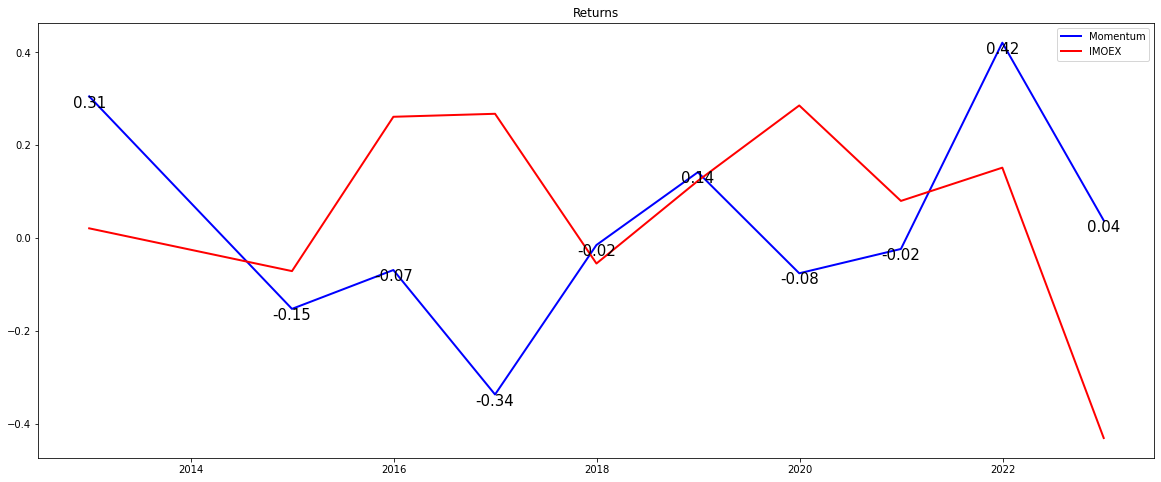

In [120]:
# Create the first plot for returns
fig1, ax1 = plt.subplots(figsize=(20, 8))
ax1.plot(yearly_results.index, yearly_results['return'], linewidth=2.0, color='blue', label='Momentum')
ax1.plot(yearly_results.index, yearly_results['return_imoex'], linewidth=2.0, color='red', label='IMOEX')
for i, y in enumerate(yearly_results['return']):
    ax1.text(yearly_results.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax1.set_title('Returns')
ax1.legend()
plt.savefig('returns_2012-2022.jpg', bbox_inches='tight', dpi=100)
plt.show()

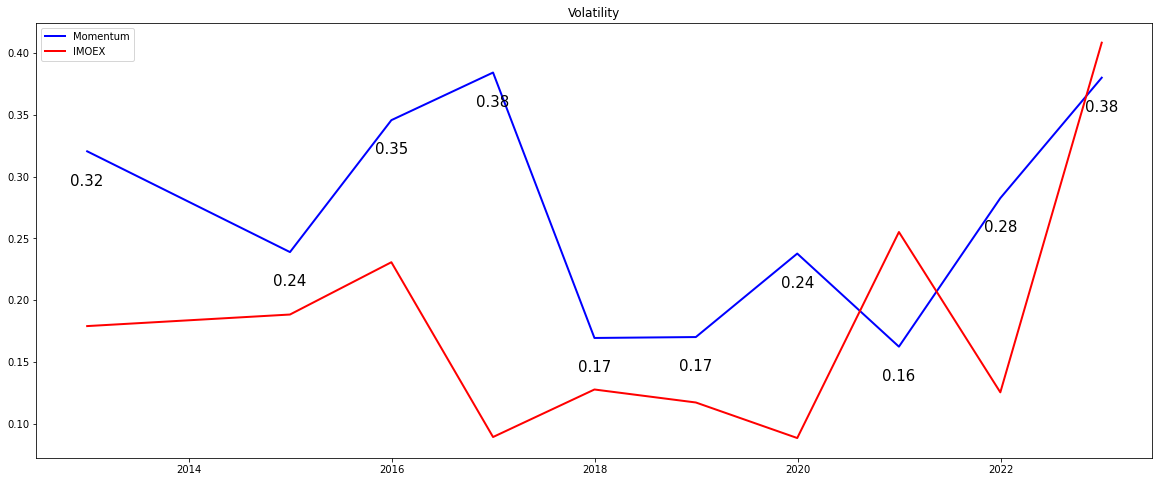

In [121]:
# Create the second plot for volatility
fig2, ax2 = plt.subplots(figsize=(20, 8))
ax2.plot(yearly_results.index, yearly_results['volatility'], linewidth=2.0, color='blue', label='Momentum')
ax2.plot(yearly_results.index, yearly_results['volatility_imoex'], linewidth=2.0, color='red', label='IMOEX')
for i, y in enumerate(yearly_results['volatility']):
    ax2.text(yearly_results.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax2.set_title('Volatility')
ax2.legend()
plt.savefig('volatility_2012-2022.jpg', bbox_inches='tight', dpi=100)
plt.show()

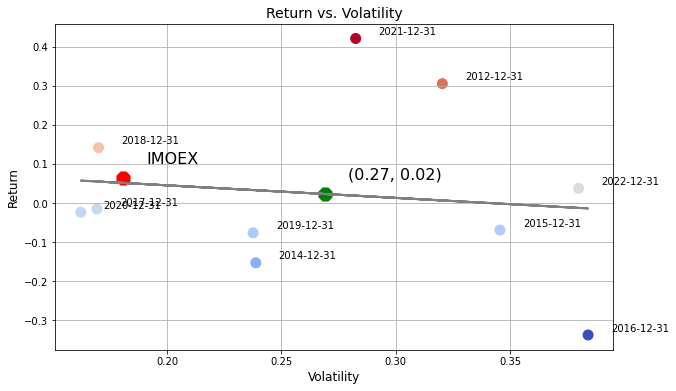

Weighted average return: 0.02310381075846677
Weighted average volatility: 0.26907415576267785


In [123]:
# Create scatter plot with text annotations and trend line
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.scatter(yearly_results['volatility'], yearly_results['return'], s=100, c=yearly_results['return'], cmap='coolwarm')

ax.scatter( yearly_results['volatility'].mean(),yearly_results['return'].mean(), color = 'green',marker = '8', s = 200)
ax.scatter(yearly_results['volatility_imoex'].mean(),yearly_results['return_imoex'].mean(), color = 'red',marker = '8', s = 200)

for i, year_range in enumerate(yearly_results.index.strftime('%Y-%m-%d')):
    ax.text(yearly_results['volatility'][i] + 0.01, yearly_results['return'][i] + 0.01, year_range, fontsize=10)
z = np.polyfit(yearly_results['volatility'], yearly_results['return'], 1)
p = np.poly1d(z)
ax.plot(yearly_results['volatility'], p(yearly_results['volatility']), "-", color='gray', linewidth=2)

# Set labels and title
ax.set_xlabel('Volatility', fontsize=12)
ax.set_ylabel('Return', fontsize=12)
ax.set_title('Return vs. Volatility', fontsize=14)

ax.annotate((yearly_results['volatility'].mean().round(2),yearly_results['return'].mean().round(2)), (yearly_results['volatility'].mean()+ 0.01, yearly_results['return'].mean()+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')
ax.annotate(('IMOEX'), (yearly_results['volatility_imoex'].mean()+ 0.01, yearly_results['return_imoex'].mean()+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')


# Add colorbar
#fig.colorbar(im, ax=ax)

# Add grid
ax.grid()
plt.savefig('ret vs vol weighted.jpg', bbox_inches='tight', dpi = 100)
plt.show()
print("Weighted average return:", yearly_results['return'].mean())
print("Weighted average volatility:", yearly_results['volatility'].mean())

In [126]:
yearly_results['return_imoex'].mean(),yearly_results['volatility_imoex'].mean()

(0.06316634920983842, 0.1808490377030006)

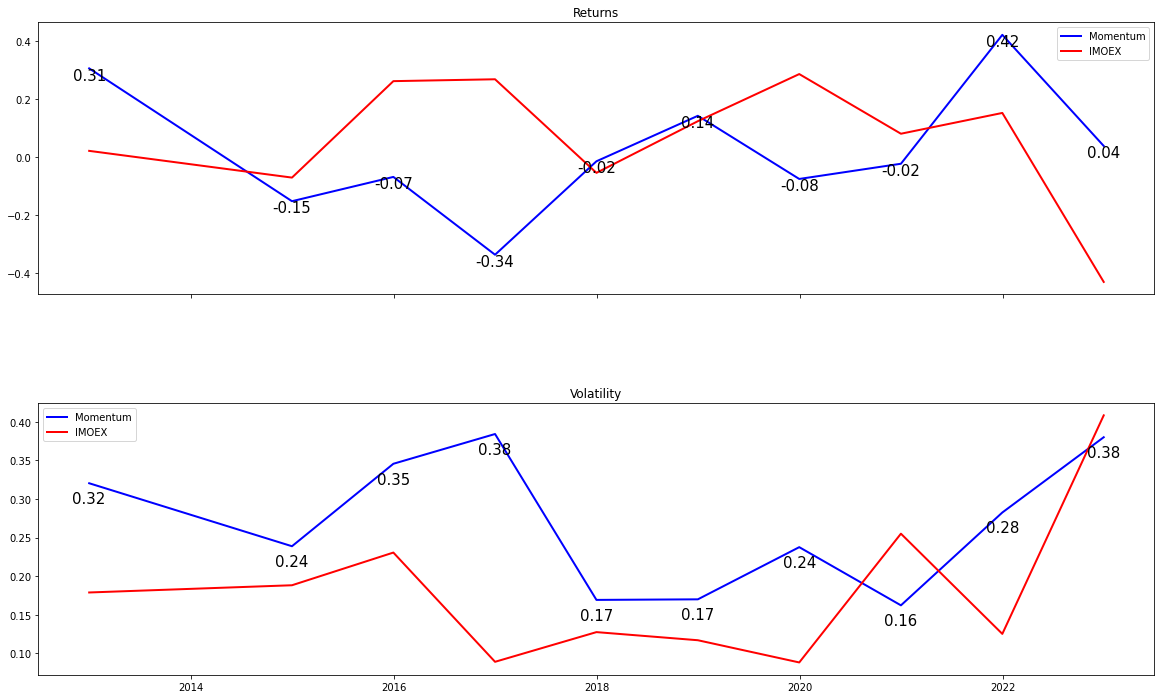

In [146]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12), sharex=True)

# plot returns
ax1.plot(yearly_results.index, yearly_results['return'], linewidth=2.0, color = 'blue', label = 'Momentum')
ax1.plot(yearly_results.index, yearly_results['return_imoex'], linewidth=2.0, color = 'red', label = 'IMOEX')
for i, y in enumerate(yearly_results['return']):
    ax1.text(yearly_results.index[i], y - 0.05, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax1.set_title('Returns')
ax1.legend()

# plot volatility
ax2.plot(yearly_results.index, yearly_results['volatility'], linewidth=2.0, color = 'blue', label = 'Momentum')
ax2.plot(yearly_results.index, yearly_results['volatility_imoex'], linewidth=2.0, color = 'red', label = 'IMOEX')
for i, y in enumerate(yearly_results['volatility']):
    ax2.text(yearly_results.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax2.set_title('Volatility')
ax2.legend()
# adjust layout
plt.subplots_adjust(hspace=0.4)

plt.savefig('momentum_in_one.jpg', bbox_inches='tight', dpi = 100)

# show the plot
plt.show()


In [136]:
yearly_results

,return,volatility,return_imoex,volatility_imoex,excess,outperformed
2012-12-31,0.305187,0.320404,0.020737,0.178912,0.284450,Yes
2014-12-31,-0.152854,0.238819,-0.071452,0.188268,-0.081402,No
2015-12-31,-0.069111,0.345629,0.261168,0.230614,-0.330279,No
2016-12-31,-0.337395,0.384174,0.267611,0.089106,-0.605006,No
2017-12-31,-0.015176,0.169295,-0.055081,0.127571,0.039904,Yes
2018-12-31,0.141656,0.170031,0.123044,0.117054,0.018612,Yes
2019-12-31,-0.076132,0.237617,0.285541,0.088280,-0.361672,No
2020-12-31,-0.023688,0.162257,0.079829,0.255065,-0.103518,No
2021-12-31,0.420858,0.282508,0.151486,0.125273,0.269373,Yes
2022-12-31,0.037693,0.380009,-0.431219,0.408346,0.468912,Yes
